 mlflow ui --backend-store-uri sqlite:///mlruns.db

In [61]:
#Importações
import pandas as pd
from sklearn.model_selection import train_test_split
import mlflow
from pycaret.datasets import get_data
from pycaret.classification import *
import os
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import time



In [62]:
# importação data set  https://www.kaggle.com/c/kobe-bryant-shot-selection/data
df = pd.read_parquet("../data/raw/dataset_kobe_dev.parquet")
df.shape
# df_origianal.columns

df_prod = pd.read_parquet("../data/raw/dataset_kobe_prod.parquet")

url_docs_artefatos = "../docs/artefatos"

In [63]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'PreparacaoDados'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

In [64]:
#função para adicionar data frame como artefato 
def adicionaDataFrameArtefato(df, titulo,pasta):
    #Salvar o DataFrame como arquivo parquet
    arquivo_path = f"../data/{pasta}/{titulo}.parquet"
    df.to_parquet(arquivo_path, index=False)
    # Registrando o DataFrame resultante como um artefato no MLflow
    mlflow.log_artifact(arquivo_path, f"{titulo}.parquet")

In [65]:
#variavel com caminho do csv temporario, este foi criado para ser salvo como um aterfato no mlflow
csv_path = ''

def dadosNulosArtefato(df,titulo):
    # Contagem de valores nulos por coluna
    valores_nulos_por_coluna = df.isnull().sum()

    # Criando um DataFrame para exibir os resultados
    tabela_valores_nulos = pd.DataFrame(valores_nulos_por_coluna, columns=['Valores Nulos'])

    # Resetando o índice para manter os nomes das colunas
    tabela_valores_nulos.reset_index(inplace=True)

    # Salvando o DataFrame como um arquivo CSV 
    csv_path = f"{url_docs_artefatos}/texto/{titulo}.csv"
    tabela_valores_nulos.to_csv(csv_path, index=False)
    
    #Adicionado um atefato em formato csv com para listar os campos nullos
    mlflow.log_artifact(csv_path, artifact_path= f"{titulo}.csv")
    
   # os.remove(csv_path) 

In [66]:

csv_shape = ""

def shapeArtefato(df, titulo):
    # Obtendo o número de linhas e colunas do DataFrame
    num_linhas = df.shape[0]
    num_colunas = df.shape[1]
    # Criando um DataFrame com as informações
    info_shape = pd.DataFrame({'Número de Linhas': [num_linhas], 'Número de Colunas': [num_colunas]})

    # Salvando o DataFrame como um arquivo CSV 
    csv_shape = f"{url_docs_artefatos}/texto/{titulo}.csv"
    info_shape.to_csv(csv_shape, index=False)
    #Adicionado artefato com a quantidade inicial de linha e colunas 
    mlflow.log_artifact(csv_shape, artifact_path=f"{titulo}.csv")
    #os.remove(csv_shape)

In [67]:
#Criando artefato com os nomes da colunas originais e sua tipagem
def colunasArtefato(df, titulo):
    # Capturando as informações de df.info() em uma string
    info_buffer = StringIO()
    df.info(buf=info_buffer)
    info_text = info_buffer.getvalue()
      # Criando o caminho para a pasta
    
    pasta_path = os.path.join(url_docs_artefatos,'texto')
    os.makedirs(pasta_path, exist_ok=True)
    
    # Salvando o arquivo de texto na pasta
    file_path = os.path.join(pasta_path, f"{titulo}.txt")
    with open(file_path, "w") as file:
        file.write(info_text)
    mlflow.log_text(info_text, artifact_file=f"{titulo}.txt")

In [68]:
def dataFrameArtefato(df, titulo,pasta):
    #Colunas que irão permanecer na base de dados
    colunas_selecionadas = ['lat', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
    #excutando a remoção de colunas e linha que tenha valores nuloes    
    df_processado = df[colunas_selecionadas].dropna()
    colunasArtefato(df_processado, f"colunas_{titulo}")
    shapeArtefato(df_processado, f"shape_{titulo}")
    dadosNulosArtefato(df_processado,f"valores_nulos_{titulo}") 
    
    # Registrando o DataFrame resultante como um artefato no MLflow
    adicionaDataFrameArtefato(df_processado,titulo,pasta)
    
 

In [69]:
def boxplot_faixa_dinamica(df,pasta):
   # dfp =  pd.read_parquet("../data/processed/data_filtered.parquet")
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, palette="Set3", linewidth=2.5)
    plt.title("Gráfico de Box Plot - Faixa Dinâmica das Variáveis")
    plt.xlabel("Variáveis")
    plt.ylabel("Valores")
    plt.xticks(rotation=45)
  #  plt.tight_layout()
    
    # Salvar o gráfico como uma imagem temporária
    temp_file =  f"{url_docs_artefatos}/graficos/{pasta}/boxplot_faixa_dinamica.png"
    plt.savefig(temp_file)
    mlflow.log_artifact(temp_file, artifact_path="boxplot_faixa_dinamica.png")
    
  #  plt.show()

In [70]:
def histogramaVariaveis(df,pasta):
    #dfp =  pd.read_parquet("../data/processed/data_filtered.parquet") 
    plt.figure(figsize=(12, 8))
    df.hist(figsize=(12, 8))
    plt.suptitle("Histograma das Variáveis", fontsize=16)
    plt.tight_layout()
    histogram_path =  f"{url_docs_artefatos}/graficos/{pasta}/histograma.png"
    plt.savefig(histogram_path)
    plt.close()
    mlflow.log_artifact(histogram_path, artifact_path="histograma.png")

In [71]:
def matrixCorrelacao(df,pasta):
   # dfp =  pd.read_parquet("../data/processed/data_filtered.parquet")
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de Correlação", fontsize=16)
    plt.tight_layout()
    
    # Salvar o gráfico como um arquivo temporário
    temp_file =  f"{url_docs_artefatos}/graficos/{pasta}/matriz_correlacao.png"
    plt.savefig(temp_file)
    plt.close()
    
    mlflow.log_artifact(temp_file, artifact_path="matriz_correlacao.png")


In [72]:
def plotScatterMatrix(df,pasta):
    scatter_matrix(df, diagonal='hist', figsize=(15, 15))
    plt.suptitle("Matriz de Gráficos de Dispersão", y=0.90, fontsize=16)
    plt.tight_layout()
    
    # Salvar o gráfico como um arquivo temporário
    temp_file = f"{url_docs_artefatos}/graficos/{pasta}/scatter_matrix.png"
    plt.savefig(temp_file)
    plt.close()
    mlflow.log_artifact(temp_file, artifact_path="scatter_matrix.png")


In [73]:
def csvDescribe(df, pasta):
      # Obter estatísticas resumidas usando o método describe()
    describe_stats = df.describe()
    
    # Converter as estatísticas resumidas para uma string
    describe_string = describe_stats.to_string()

    # Caminho do arquivo temporário para salvar as estatísticas resumidas
    temp_path = f"{url_docs_artefatos}/{pasta}/describe_statistics.txt"
    
    # Salvar as estatísticas resumidas em um arquivo de texto
    with open(temp_path, "w") as file:
        file.write(describe_string)
    
    # Registrar o arquivo de texto como um artefato no MLflow
    mlflow.log_artifact(temp_path, artifact_path="describe_statistics.txt")


In [74]:
df.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,24271.000000,2.427100e+04,24271.000000,24271.000000,24271.000000,24271.000000,24271.000000,24271.000000,24271.000000,24271.000000,24271.000000,20285.000000,2.427100e+04,24271.000000
mean,240.571464,2.483294e+07,33.980603,7.407935,63.697417,-118.262392,5.091591,2.470520,0.149026,28.758271,10.222076,0.477348,1.610613e+09,15160.124593
std,148.513569,7.816366e+06,0.065872,93.601652,65.871523,0.093602,3.420637,1.149706,0.356121,17.390267,7.574579,0.499499,0.000000e+00,9010.341515
min,2.000000,2.000001e+07,33.543300,-218.000000,-44.000000,-118.487800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,102.000000,2.040094e+07,33.925300,-44.000000,0.000000,-118.313800,2.000000,1.000000,0.000000,14.000000,1.000000,0.000000,1.610613e+09,7206.500000
50%,244.000000,2.090015e+07,33.999300,0.000000,45.000000,-118.269800,5.000000,3.000000,0.000000,29.000000,12.000000,0.000000,1.610613e+09,15081.000000
75%,355.000000,2.960106e+07,34.044300,75.000000,119.000000,-118.194800,8.000000,3.000000,0.000000,44.000000,17.000000,1.000000,1.610613e+09,23268.500000
max,659.000000,4.990009e+07,34.088300,220.000000,501.000000,-118.049800,11.000000,7.000000,1.000000,59.000000,50.000000,1.000000,1.610613e+09,30697.000000


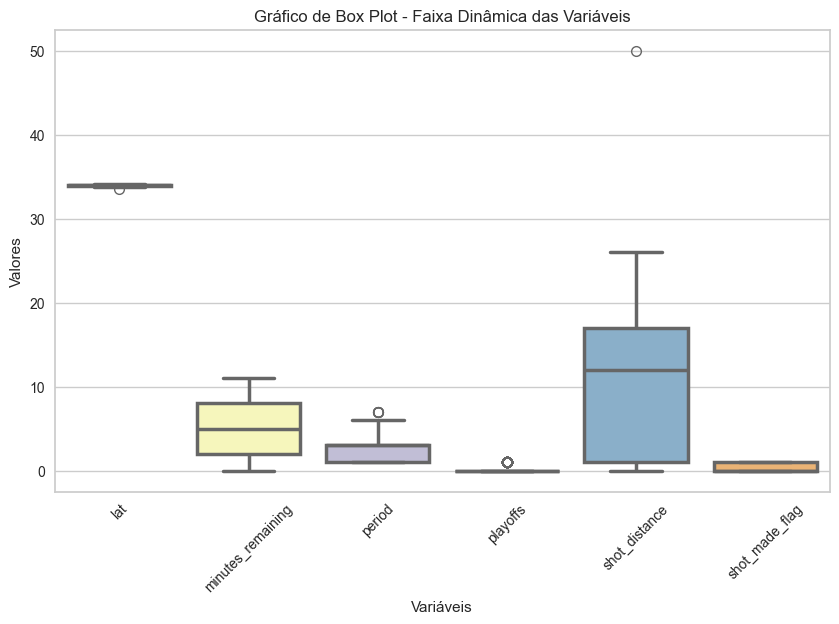

<Figure size 1200x800 with 0 Axes>

In [75]:

#MLflow
with mlflow.start_run(experiment_id=experiment_id, run_name='PreparaçãoDados'):
   
   colunasArtefato(df,"colunas_iniciais")#Adicionado artefato com os nomes das colunas e sua respecitva tipagem 
   dadosNulosArtefato(df, "valores_nulos") #Adicionado um atefato em formato csv com para listar os campos nullos
   
   shapeArtefato(df,"shape_inicial")#Adicionado artefato com a quatidade de linhas e colunas iniciais
   adicionaDataFrameArtefato(df,"dataset_kobe_dev","raw") #Adiciondo o data frame de desenvolvimento com atefato no mlflow
   adicionaDataFrameArtefato(df_prod,"dataset_kobe_prod","raw") #Adiciondo o data frame de  produção com atefato no mlflow
   dataFrameArtefato(df,"data_filtered","processed") #Processando o data frame removendo algumas colunas e salvando o mesmo no mlflow
   
  
   """
    Os artefatos abaixo são criados após o processamento dos dados. 
    Como esse processo pode levar algum tempo, uma validação foi adicionada para verificar se o arquivo já foi criado.
    Se o arquivo já existe, os artefatos são criados a partir dele. Caso contrário, o processo de criação dos artefatos é iniciado.
   """ 
   file_path = "../data/processed/data_filtered.parquet"
   attempts = 0
   max_attempts=100
   while attempts < max_attempts:
        if os.path.exists(file_path):  # Verifica se o arquivo existe
            data_filtered =  pd.read_parquet("../data/processed/data_filtered.parquet")
            boxplot_faixa_dinamica(data_filtered,"pre_processamento")#adicioando grafico faixa dinamica como artefato
            histogramaVariaveis(data_filtered,"pre_processamento")#adicionado o histograma como artefato
            matrixCorrelacao(data_filtered,"pre_processamento")#adicionando matriz de correlação como artefato
            plotScatterMatrix(data_filtered,"pre_processamento")#adicinando plot scatter marix como artefato 
            csvDescribe(data_filtered, "texto")# # Adiciona o gráfico da faixa dinâmica como artefato
            break
        else:
            print(f"O arquivo {file_path} não foi encontrado. Tentando novamente em 5 segundos...")
            time.sleep(5)  # Espera 5 segundos antes de tentar novamente
            attempts += 1
   else:
        print(f"Não foi possível encontrar o arquivo após {max_attempts} tentativas.")


